In [148]:
%load_ext autoreload
%autoreload 2
from helper import create_tsp_graph,plot_tsp_graph,bitstring_to_path,cost
from classical import solve_tsp_classical
from alternating_operator import get_expectation,analyse_result,create_qaoa_circ
from scipy.optimize import minimize
from qiskit.tools.visualization import plot_histogram
from qiskit import transpile,Aer
from qaoa import get_expectation_qaoa,create_classical_qaoa_circ
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
reps = 1
ncities = 6

In [150]:
G = create_tsp_graph(ncities)

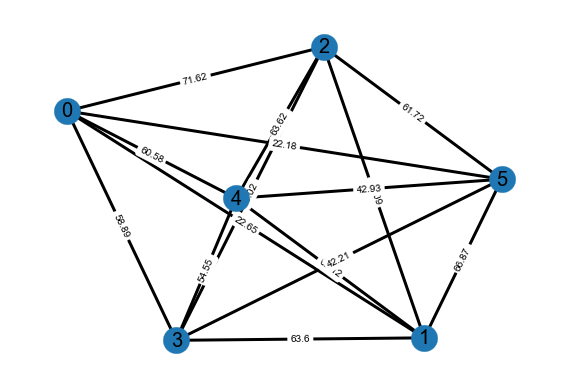

In [151]:
plot_tsp_graph(G)

In [152]:
expectation = get_expectation(G,reps,shots=1024,log_intermediate_counts=True)

res = minimize(expectation,
               [np.random.rand()*3 for _ in range(reps*4)] ,
                      method='COBYLA',
                      options = {'tol' : 1e-4,'disp' : True,'maxiter':100})

Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


Current expected cost: 282.3
Current expected cost: 282.3
Current expected cost: 282.3
Current expected cost: 229.3
Current expected cost: 229.3
Current expected cost: 240.86
Current expected cost: 216.38
Current expected cost: 255.64
Current expected cost: 216.38
Current expected cost: 260.83
Current expected cost: 216.38
Current expected cost: 271.74
Current expected cost: 269.2
Current expected cost: 260.65
Current expected cost: 281.84
Current expected cost: 217.98
Current expected cost: 216.38
Current expected cost: 251.57
Current expected cost: 216.38
Current expected cost: 247.67
Current expected cost: 269.39
Current expected cost: 240.31
Current expected cost: 221.77
Current expected cost: 216.38
Current expected cost: 215.41
Current expected cost: 215.41
Current expected cost: 228.87
Current expected cost: 215.41
Current expected cost: 229.69
Current expected cost: 219.55
Current expected cost: 216.54
Current expected cost: 215.41
Current expected cost: 216.57
Current expected

In [153]:
with open(".\data\G", "wb") as fp:   #Pickling
    pickle.dump(G,fp)

In [154]:
res

     fun: 215.41288247934824
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 46
  status: 1
 success: True
       x: array([1.78910654, 1.24813628, 2.74891567, 2.17519479])

Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


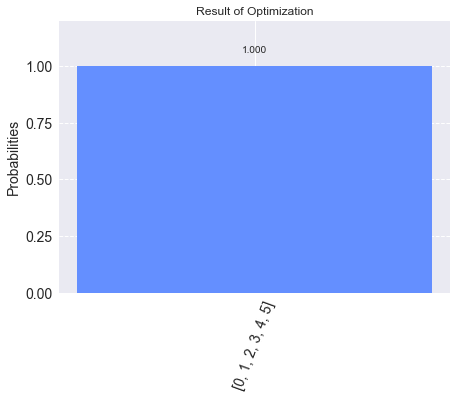

In [155]:
fig,counts = analyse_result(G,res.x,reps=reps,transform_labels_to_path=True,filter_unique_path=True,save_plot=True)
fig

In [156]:
for key, val in counts.items():
    if val>1:
        path = bitstring_to_path(key)
        print(path,':', val , f"   cost = {round(cost(G,path),2)}")

[0, 1, 2, 3, 4, 5] : 1024    cost = 215.41


In [9]:
from itertools import permutations
for p in permutations([0,1,2,3]):
    print(p,':',cost(G,p))

(0, 1, 2, 3) : 183.79577039525228
(0, 1, 3, 2) : 240.2901265500841
(0, 2, 1, 3) : 282.1419518766385
(0, 2, 3, 1) : 240.2901265500841
(0, 3, 1, 2) : 282.1419518766385
(0, 3, 2, 1) : 183.7957703952523
(1, 0, 2, 3) : 240.29012655008412
(1, 0, 3, 2) : 183.7957703952523
(1, 2, 0, 3) : 282.1419518766385
(1, 2, 3, 0) : 183.7957703952523
(1, 3, 0, 2) : 282.1419518766385
(1, 3, 2, 0) : 240.2901265500841
(2, 0, 1, 3) : 240.2901265500841
(2, 0, 3, 1) : 282.1419518766385
(2, 1, 0, 3) : 183.7957703952523
(2, 1, 3, 0) : 282.1419518766385
(2, 3, 0, 1) : 183.7957703952523
(2, 3, 1, 0) : 240.2901265500841
(3, 0, 1, 2) : 183.7957703952523
(3, 0, 2, 1) : 282.1419518766385
(3, 1, 0, 2) : 240.2901265500841
(3, 1, 2, 0) : 282.1419518766385
(3, 2, 0, 1) : 240.2901265500841
(3, 2, 1, 0) : 183.7957703952523


In [157]:
solve_tsp_classical(G)

([0, 1, 2, 3, 4, 5], 215.41288247934824)

In [158]:
expectation_qaoa = get_expectation_qaoa(G,reps,shots=1024,penalty=1.,log_intermediate_counts=True)

res_qaoa = minimize(expectation_qaoa,
               [1 for _ in range(reps*2)] ,
                      method='COBYLA',
                      options = {'tol' : 1e-4,'disp' : True})

Current expected cost: 429.73
Current expected cost: 429.73
Current expected cost: 429.73
Current expected cost: 429.73
Current expected cost: 429.73
Current expected cost: 429.73
Current expected cost: 429.73
Current expected cost: 429.73
Current expected cost: 429.73
Current expected cost: 429.73
Current expected cost: 429.73
Current expected cost: 429.73
Current expected cost: 429.73


In [159]:
res_qaoa

     fun: 429.7336508999579
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 13
  status: 1
 success: True
       x: array([1., 1.])

Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


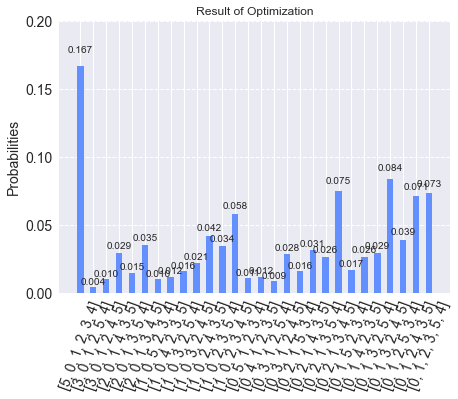

In [160]:
fig,counts = analyse_result(G,np.hstack([np.array([1.,1.]),res_qaoa.x]),reps=reps,transform_labels_to_path=True,filter_unique_path=True)
fig

In [162]:
with open(f".\\data\\alternating_operator_counts", "rb") as fp:   # Unpickling
    alternating_operator_counts = pickle.load(fp)

In [165]:
for shot in alternating_operator_counts:
    cnt = 0
    for _,val in shot.items():
        cnt += val
    print(cnt)
    

[{'100000010000001000000100000001000010': 28,
  '010000100000001000000010000100000001': 26,
  '010000100000001000000100000001000010': 30,
  '001000100000010000000010000100000001': 36,
  '100000000010010000001000000100000001': 34,
  '001000100000010000000100000001000010': 32,
  '100000000001010000001000000100000010': 50,
  '100000001000010000000100000001000010': 29,
  '100000001000010000000100000010000001': 17,
  '010000100000000001001000000100000010': 39,
  '010000100000001000000100000010000001': 23,
  '001000100000010000000100000010000001': 27,
  '000010100000010000001000000100000001': 41,
  '100000010000000100001000000001000010': 29,
  '100000000100010000001000000001000010': 29,
  '000001100000010000001000000100000010': 46,
  '010000100000000100001000000001000010': 36,
  '100000010000000001001000000100000010': 31,
  '100000010000000010001000000100000001': 34,
  '100000010000001000000010000100000001': 27,
  '010000100000000100001000000010000001': 37,
  '0100001000000010000000010001000

In [121]:
def compute_circuit_sizes(ncities_max=6,reps=1):
    sizes_alternating_operator = []
    sizes_qaoa = []
    simulator = Aer.get_backend('aer_simulator')
    x = []
    
    for ncities in range(2,ncities_max+1,1):
        G = create_tsp_graph(ncities)
        x.append(ncities)
        
        alt_op = create_qaoa_circ(G,reps=reps)
        alt_op = transpile(alt_op, simulator,optimization_level = 3)
        sizes_alternating_operator.append(alt_op.depth())
        
        qaoa = create_classical_qaoa_circ(G,reps=reps)
        # for qaoa opt level 1 works the best
        qaoa = transpile(qaoa, simulator,optimization_level = 1)
        sizes_qaoa.append(qaoa.depth())
    
    
    return (x,sizes_alternating_operator,sizes_qaoa)
        

In [122]:
compute_circuit_sizes(5,1)

Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


([2, 3, 4, 5], [69, 386, 830, 1402], [7, 20, 45, 109])